In [1]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F 

from torchvision import transforms 
from torchvision.io import read_image 
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18, ResNet18_Weights

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import os 
import random 
from tqdm import tqdm 

%matplotlib inline 

In [2]:
torch.cuda.is_available()

True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Data processing 

In [4]:
data_dir = '/kaggle/input/pascal-voc-2012/VOC2012'
img_dir = os.path.join(data_dir, 'JPEGImages')                         # original images
img_names_dir = os.path.join(data_dir, 'ImageSets', 'Segmentation')    # image names 
label_dir = os.path.join(data_dir, 'SegmentationClass')                # segmented images 

In [5]:
len(os.listdir(img_dir))

17125

In [6]:
train_img_file = os.path.join(img_names_dir, 'train.txt')
with open(train_img_file, 'r') as f: 
    train_img_names = f.read().split()              # a list of train image names 
    
print(len(train_img_names))
print(train_img_names[:5])

1464
['2007_000032', '2007_000039', '2007_000063', '2007_000068', '2007_000121']


In [7]:
val_img_file = os.path.join(img_names_dir, 'trainval.txt')
with open(val_img_file, 'r') as f: 
    val_img_names = f.read().split()              # train + val image names 
    
print(len(val_img_names))

2913


In [8]:
valid_img_file = os.path.join(img_names_dir, 'val.txt')
with open(valid_img_file, 'r') as f: 
    valid_img_names = f.read().split()              # valid images  
    
print(len(valid_img_names))

1449


In [9]:
mode = torchvision.io.image.ImageReadMode.RGB    # read RGB image 

In [10]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=3): 
    """Plot a list of images.
    
    NOTE: Input image shape: (c, h, w)
    """
    
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)): 
        ax.imshow(img.permute(1, 2, 0))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        if titles is not None: 
            ax.set_title(titles[i])
            
    plt.show()

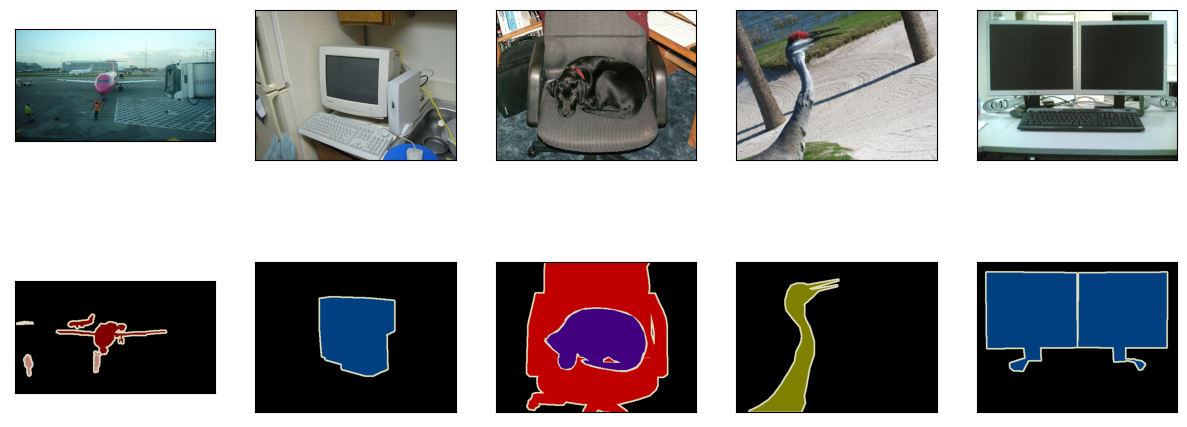

In [11]:
# show 5 first train images 
n = 10 
num_rows, num_cols = 2, 5

imgs, labels = [], []
img_names = train_img_names[:5]
for img_name in img_names: 
    img = read_image(os.path.join(img_dir, f'{img_name}.jpg'))              # JPEG images 
    label = read_image(os.path.join(label_dir, f'{img_name}.png'), mode)    # PNG images 
    imgs.append(img)
    labels.append(label)
    
imgs += labels 
show_images(imgs, num_rows, num_cols)

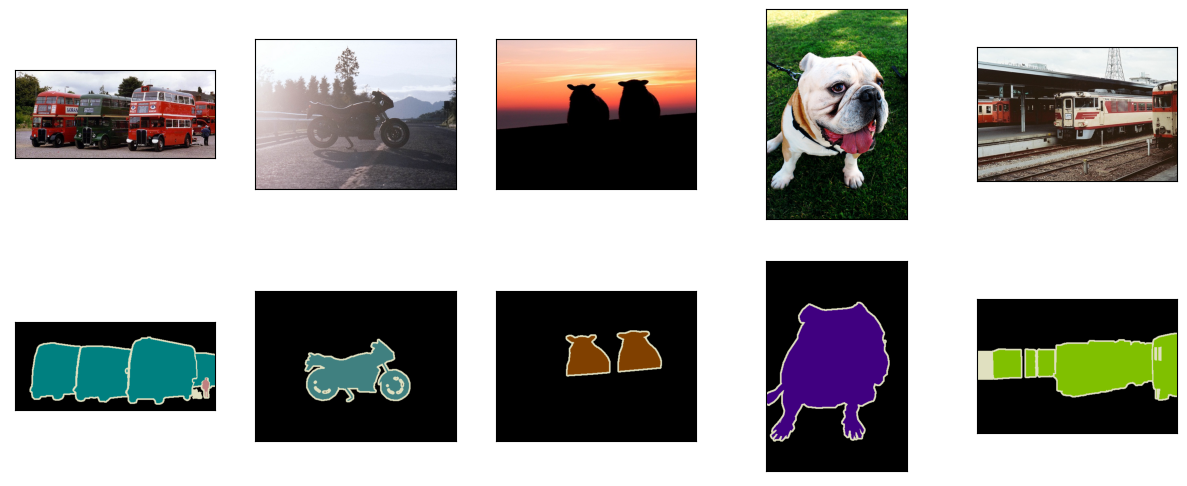

In [12]:
# show 5 random train images 
n = 10 
num_rows, num_cols = 2, 5

imgs, labels = [], []
img_names = random.sample(train_img_names, 5)
for img_name in img_names: 
    img = read_image(os.path.join(img_dir, f'{img_name}.jpg'))              # JPEG images 
    label = read_image(os.path.join(label_dir, f'{img_name}.png'), mode)    # PNG images 
    imgs.append(img)
    labels.append(label)
    
imgs += labels 
show_images(imgs, num_rows, num_cols)

In [13]:
classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

colormaps = [
    [0, 0, 0],        # background is all black 
    [128, 0, 0],      # aerophane 
    [0, 128, 0],      # bicycle 
    [128, 128, 0],    # ...
    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]
]

In [14]:
def colormap2label(colormaps): 
    """Build the mapping from COLORMAP to CLASSES indices for label images.
    """

    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(colormaps): 
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

    return colormap2label


def label_to_idx(colormap, colormap2label):
    """Map any RGB values in label images to their class indices.
    """
    
    # permute the height and width to be in the beginning 
    colormap = colormap.permute(1, 2, 0).numpy().astype("int32")      
    idx = (colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]

    return colormap2label[idx] 

In [15]:
# in the first example image, the class index for the front part of the airplane is 1, 
# while the background index is 0.
img = read_image(os.path.join(img_dir, f'{train_img_names[0]}.jpg'))
label = read_image(os.path.join(label_dir, f'{train_img_names[0]}.png'), mode)

y = label_to_idx(label, colormap2label(colormaps))

print(y[105:115, 130:140])
print(classes[1])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])
aeroplane


# Random crop

In [16]:
def random_crop(image, label, height, width): 
    """Randomly crop the same area of input and label images.
    """

    rect = transforms.RandomCrop.get_params(image, (height, width))   # get parameters for a random crop 
    
    image = transforms.functional.crop(image, *rect)
    label = transforms.functional.crop(label, *rect)

    return image, label 

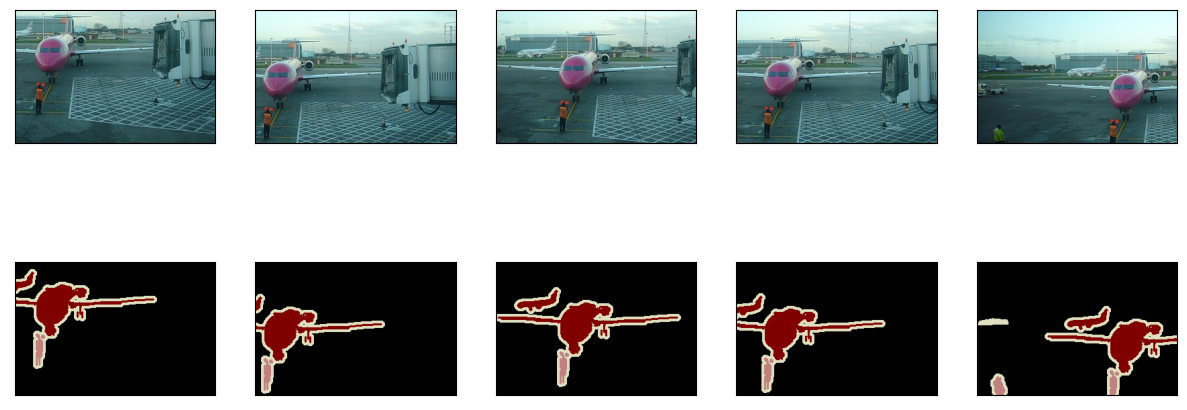

In [17]:
# get different random crop of a single image 
n = 5
imgs = []
for _ in range(n): 
    imgs += random_crop(img, label, 200, 300)    # get a (3, 200, 300) image

show_images(imgs[::2] + imgs[1::2], 2, n)

# Custom Dataset

In [18]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

crop_size = (320, 480)

In [19]:
class CustomVOCDataset(Dataset): 
    """A customized dataset to load VOC Pascal 2012 dataset.
    """
    
    def __init__(self, img_dir, label_dir, img_names, transform, crop_size, colormap2label): 
        """Read train or valid data.
        """
        
        self.img_dir = img_dir 
        self.label_dir = label_dir
        self.img_names = img_names 
        self.transform = transform 
        self.crop_size = crop_size 
        self.colormap2label = colormap2label
        
        # load images and labels 
        images, labels = [], []
        for i, img_name in tqdm(enumerate(self.img_names)): 
            images.append(read_image(os.path.join(self.img_dir, f'{img_name}.jpg')))
            labels.append(read_image(os.path.join(self.label_dir, f'{img_name}.png'), mode))
            
        # filter and normalize images and labels 
        self.images = [self._normalize(image) for image in self._filter(images)]
        self.labels = self._filter(labels)
    
    def _normalize(self, img): 
        """Convert an image to the range of [0, 1].
        """
        
        return self.transform(img.float() / 255)           
    
    def _filter(self, imgs): 
        """Filter images that have (height, width) >= crop_size.
        """
        
        return [img for img in imgs if (img.shape[1] >= self.crop_size[0] and 
                                        img.shape[2] >= self.crop_size[1])]
    
    def __len__(self): 
        return len(self.images)
    
    def __getitem__(self, idx): 
        image, label = random_crop(self.images[idx], self.labels[idx], *self.crop_size)
        label = label_to_idx(label, self.colormap2label)                # convert label image to classes
        
        return image, label 

# Reading the dataset 

In [20]:
train_data = CustomVOCDataset(img_dir, label_dir, train_img_names, transform, crop_size, colormap2label(colormaps))
valid_data = CustomVOCDataset(img_dir, label_dir, valid_img_names, transform, crop_size, colormap2label(colormaps))

print(len(train_data))
print(len(valid_data))

1464it [00:17, 83.21it/s]
1449it [00:18, 78.11it/s]


1114
1078


In [21]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

print(len(train_loader))
print(len(valid_loader))

18
17


In [22]:
train_imgs, train_labels = next(iter(train_loader))

print(train_imgs.shape)
print(train_labels.shape)

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


# Define model

In [23]:
list(resnet18(weights=ResNet18_Weights.DEFAULT).children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [24]:
def define_model(device, num_classes=21): 
    """Create fully convolutional network with ResNet18 backbone.
    """
    
    pretrained_net = resnet18(weights=ResNet18_Weights.DEFAULT)
    
    # copy all the pretrained layers in ResNet18, except the final AvePool layer and FCL
    model = nn.Sequential(*list(pretrained_net.children())[:-2])
    
    # add 1x1 conv layer to transform the number of channels into the number of classes (21)
    model.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
    
    # increase the height and width of the feature map by 32 times to get back to the input's shape 
    model.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))
    
    return model.to(device)

In [25]:
X = torch.rand(size=(1, 3, 320, 480)).to(device)

model = define_model(device)

outputs = model(X)

print(outputs.shape)

_, predicted = torch.max(outputs, dim=1)

print(predicted.shape)

torch.Size([1, 21, 320, 480])
torch.Size([1, 320, 480])


In [26]:
def bilinear_kernel(in_channels, out_channels, kernel_size): 
    """Initialize the kernel's weights of transposed convolutional layers by bilinear interpolation.
    """
    
    factor = (kernel_size + 1) // 2 
    if kernel_size % 2 == 1: 
        center = factor - 1
    else: 
        center = factor - 0.5 
        
    og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt 
    
    return weight 

torch.Size([1, 3, 281, 500])
torch.Size([1, 3, 562, 1000])
torch.Size([562, 1000, 3])


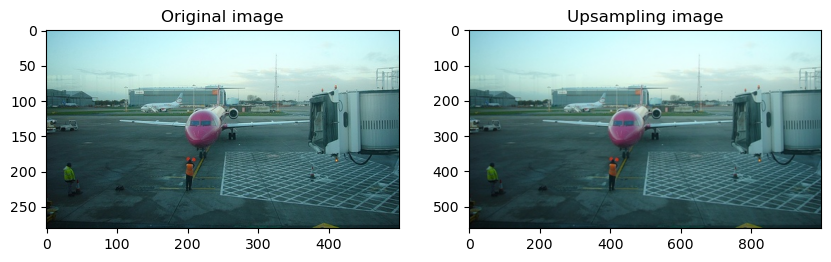

In [27]:
# experiment with upsampling of bilinear interpolation implemented by a transposed convolutional layer 
# construct a transposed convolutional layer that doubles the height and width 
# initialize its kernel with bilinear_kernel function 

conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

img = read_image(os.path.join(img_dir, f'{train_img_names[0]}.jpg'))
img = img.float() / 255

X = img.unsqueeze(0)                          # create batch_size dimension 
print(X.shape)

Y = conv_trans(X)
print(Y.shape)

out_img = Y[0].permute(1, 2, 0).detach()      # The result will never require gradient
print(out_img.shape)

fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))          
plt.title('Original image')

fig.add_subplot(1, 2, 2)
plt.imshow(out_img)          
plt.title('Upsampling image')

plt.show()

# Model Config

In [28]:
num_classes = 21
num_epochs = 50
model_path = 'checkpoint.pt'

model = define_model(device)
weights = bilinear_kernel(num_classes, num_classes, 64)
model.transpose_conv.weight.data.copy_(weights)

loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Training 

In [29]:
def train_valid(model, train_loader, valid_loader, num_epochs, loss_fn, optimizer, scheduler, device, model_path): 
    """Fit the model in a given number of epochs. 
    """
    
    train_losses, valid_losses = [], []
    best_valid_loss = 10_000
    
    for epoch in range(num_epochs): 
        print(f'Epoch {epoch + 1}: ') 
        
        model.train()            # make sure gradient tracking is on 
        
        train_loss = 0.0 
        for _, (imgs, labels) in tqdm(enumerate(train_loader)): 
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            # scheduler.step()
            
            train_loss += loss.item()                              # sum the losses over the current epoch 
            
        # validate 
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():                                       # do not need gradient here
            for _, (imgs, labels) in tqdm(enumerate(valid_loader)): 
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)
                
                loss = loss_fn(outputs, labels)
                
                valid_loss += loss.item()
                
        train_loss = train_loss / len(train_loader)
        valid_loss = valid_loss / len(valid_loader)
            
        print('''Epoch {}: 
              Train loss: {:.3f}. 
              Valid loss: {:.3f}. '''.format(epoch + 1, 
                                        train_loss, 
                                        valid_loss))
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # save the best model's weights 
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_path)
        
    return train_losses, valid_losses

In [30]:
train_losses, valid_losses, = train_valid(model, 
                                         train_loader, 
                                         valid_loader, 
                                         num_epochs, 
                                         loss_fn, 
                                         optimizer, 
                                         lr_scheduler, 
                                         device, 
                                         model_path)

Epoch 1: 


18it [00:18,  1.06s/it]
17it [00:08,  1.91it/s]


Epoch 1: 
              Train loss: 2.726. 
              Valid loss: 2.137. 
Epoch 2: 


18it [00:18,  1.04s/it]
17it [00:08,  1.93it/s]


Epoch 2: 
              Train loss: 1.943. 
              Valid loss: 1.853. 
Epoch 3: 


18it [00:19,  1.06s/it]
17it [00:08,  1.89it/s]


Epoch 3: 
              Train loss: 1.755. 
              Valid loss: 1.696. 
Epoch 4: 


18it [00:19,  1.07s/it]
17it [00:08,  1.91it/s]


Epoch 4: 
              Train loss: 1.623. 
              Valid loss: 1.573. 
Epoch 5: 


18it [00:19,  1.07s/it]
17it [00:08,  1.90it/s]


Epoch 5: 
              Train loss: 1.524. 
              Valid loss: 1.480. 
Epoch 6: 


18it [00:19,  1.07s/it]
17it [00:09,  1.87it/s]


Epoch 6: 
              Train loss: 1.436. 
              Valid loss: 1.413. 
Epoch 7: 


18it [00:19,  1.06s/it]
17it [00:09,  1.85it/s]


Epoch 7: 
              Train loss: 1.364. 
              Valid loss: 1.344. 
Epoch 8: 


18it [00:18,  1.05s/it]
17it [00:09,  1.82it/s]


Epoch 8: 
              Train loss: 1.313. 
              Valid loss: 1.297. 
Epoch 9: 


18it [00:18,  1.05s/it]
17it [00:08,  1.90it/s]


Epoch 9: 
              Train loss: 1.265. 
              Valid loss: 1.253. 
Epoch 10: 


18it [00:19,  1.07s/it]
17it [00:08,  1.90it/s]


Epoch 10: 
              Train loss: 1.238. 
              Valid loss: 1.212. 
Epoch 11: 


18it [00:19,  1.07s/it]
17it [00:08,  1.91it/s]


Epoch 11: 
              Train loss: 1.203. 
              Valid loss: 1.179. 
Epoch 12: 


18it [00:19,  1.06s/it]
17it [00:09,  1.89it/s]


Epoch 12: 
              Train loss: 1.164. 
              Valid loss: 1.149. 
Epoch 13: 


18it [00:19,  1.07s/it]
17it [00:08,  1.91it/s]


Epoch 13: 
              Train loss: 1.133. 
              Valid loss: 1.127. 
Epoch 14: 


18it [00:19,  1.06s/it]
17it [00:08,  1.90it/s]


Epoch 14: 
              Train loss: 1.100. 
              Valid loss: 1.098. 
Epoch 15: 


18it [00:19,  1.06s/it]
17it [00:08,  1.90it/s]


Epoch 15: 
              Train loss: 1.090. 
              Valid loss: 1.077. 
Epoch 16: 


18it [00:19,  1.07s/it]
17it [00:08,  1.93it/s]


Epoch 16: 
              Train loss: 1.054. 
              Valid loss: 1.052. 
Epoch 17: 


18it [00:19,  1.06s/it]
17it [00:09,  1.83it/s]


Epoch 17: 
              Train loss: 1.034. 
              Valid loss: 1.037. 
Epoch 18: 


18it [00:19,  1.06s/it]
17it [00:09,  1.86it/s]


Epoch 18: 
              Train loss: 1.015. 
              Valid loss: 1.017. 
Epoch 19: 


18it [00:18,  1.05s/it]
17it [00:09,  1.85it/s]


Epoch 19: 
              Train loss: 0.996. 
              Valid loss: 1.000. 
Epoch 20: 


18it [00:19,  1.06s/it]
17it [00:08,  1.90it/s]


Epoch 20: 
              Train loss: 0.986. 
              Valid loss: 0.980. 
Epoch 21: 


18it [00:19,  1.06s/it]
17it [00:08,  1.90it/s]


Epoch 21: 
              Train loss: 0.964. 
              Valid loss: 0.968. 
Epoch 22: 


18it [00:19,  1.06s/it]
17it [00:08,  1.90it/s]


Epoch 22: 
              Train loss: 0.946. 
              Valid loss: 0.956. 
Epoch 23: 


18it [00:19,  1.07s/it]
17it [00:08,  1.92it/s]


Epoch 23: 
              Train loss: 0.934. 
              Valid loss: 0.943. 
Epoch 24: 


18it [00:19,  1.07s/it]
17it [00:08,  1.90it/s]


Epoch 24: 
              Train loss: 0.930. 
              Valid loss: 0.926. 
Epoch 25: 


18it [00:19,  1.06s/it]
17it [00:08,  1.92it/s]


Epoch 25: 
              Train loss: 0.913. 
              Valid loss: 0.917. 
Epoch 26: 


18it [00:19,  1.06s/it]
17it [00:08,  1.91it/s]


Epoch 26: 
              Train loss: 0.910. 
              Valid loss: 0.905. 
Epoch 27: 


18it [00:19,  1.06s/it]
17it [00:09,  1.86it/s]


Epoch 27: 
              Train loss: 0.894. 
              Valid loss: 0.892. 
Epoch 28: 


18it [00:18,  1.05s/it]
17it [00:09,  1.86it/s]


Epoch 28: 
              Train loss: 0.883. 
              Valid loss: 0.880. 
Epoch 29: 


18it [00:19,  1.06s/it]
17it [00:09,  1.87it/s]


Epoch 29: 
              Train loss: 0.865. 
              Valid loss: 0.871. 
Epoch 30: 


18it [00:19,  1.06s/it]
17it [00:08,  1.94it/s]


Epoch 30: 
              Train loss: 0.859. 
              Valid loss: 0.856. 
Epoch 31: 


18it [00:19,  1.06s/it]
17it [00:08,  1.92it/s]


Epoch 31: 
              Train loss: 0.857. 
              Valid loss: 0.850. 
Epoch 32: 


18it [00:19,  1.07s/it]
17it [00:08,  1.91it/s]


Epoch 32: 
              Train loss: 0.836. 
              Valid loss: 0.843. 
Epoch 33: 


18it [00:19,  1.06s/it]
17it [00:08,  1.92it/s]


Epoch 33: 
              Train loss: 0.816. 
              Valid loss: 0.834. 
Epoch 34: 


18it [00:19,  1.06s/it]
17it [00:08,  1.91it/s]


Epoch 34: 
              Train loss: 0.812. 
              Valid loss: 0.825. 
Epoch 35: 


18it [00:19,  1.06s/it]
17it [00:08,  1.90it/s]


Epoch 35: 
              Train loss: 0.801. 
              Valid loss: 0.821. 
Epoch 36: 


18it [00:19,  1.06s/it]
17it [00:08,  1.89it/s]


Epoch 36: 
              Train loss: 0.795. 
              Valid loss: 0.810. 
Epoch 37: 


18it [00:18,  1.06s/it]
17it [00:09,  1.82it/s]


Epoch 37: 
              Train loss: 0.790. 
              Valid loss: 0.802. 
Epoch 38: 


18it [00:19,  1.06s/it]
17it [00:09,  1.87it/s]


Epoch 38: 
              Train loss: 0.774. 
              Valid loss: 0.797. 
Epoch 39: 


18it [00:19,  1.06s/it]
17it [00:09,  1.87it/s]


Epoch 39: 
              Train loss: 0.761. 
              Valid loss: 0.787. 
Epoch 40: 


18it [00:18,  1.05s/it]
17it [00:08,  1.92it/s]


Epoch 40: 
              Train loss: 0.765. 
              Valid loss: 0.780. 
Epoch 41: 


18it [00:19,  1.06s/it]
17it [00:08,  1.92it/s]


Epoch 41: 
              Train loss: 0.754. 
              Valid loss: 0.772. 
Epoch 42: 


18it [00:18,  1.05s/it]
17it [00:08,  1.91it/s]


Epoch 42: 
              Train loss: 0.754. 
              Valid loss: 0.770. 
Epoch 43: 


18it [00:19,  1.07s/it]
17it [00:08,  1.91it/s]


Epoch 43: 
              Train loss: 0.740. 
              Valid loss: 0.760. 
Epoch 44: 


18it [00:18,  1.05s/it]
17it [00:08,  1.92it/s]


Epoch 44: 
              Train loss: 0.739. 
              Valid loss: 0.757. 
Epoch 45: 


18it [00:19,  1.08s/it]
17it [00:08,  1.93it/s]


Epoch 45: 
              Train loss: 0.727. 
              Valid loss: 0.750. 
Epoch 46: 


18it [00:19,  1.06s/it]
17it [00:08,  1.95it/s]


Epoch 46: 
              Train loss: 0.717. 
              Valid loss: 0.748. 
Epoch 47: 


18it [00:19,  1.06s/it]
17it [00:09,  1.85it/s]


Epoch 47: 
              Train loss: 0.715. 
              Valid loss: 0.740. 
Epoch 48: 


18it [00:19,  1.06s/it]
17it [00:09,  1.88it/s]


Epoch 48: 
              Train loss: 0.717. 
              Valid loss: 0.734. 
Epoch 49: 


18it [00:19,  1.07s/it]
17it [00:09,  1.85it/s]


Epoch 49: 
              Train loss: 0.712. 
              Valid loss: 0.729. 
Epoch 50: 


18it [00:19,  1.06s/it]
17it [00:09,  1.89it/s]

Epoch 50: 
              Train loss: 0.704. 
              Valid loss: 0.723. 


# Predict 

In [34]:
def predict(img): 
    """Standardize the input image in each channel. 
    Transform the image into 4D input format required by the CNN.
    """
    
    X = transform(img.float() / 255).unsqueeze(0)       # output shape: (1, 3, h, w)
    Y = model(X.to(device))                             # output shape: (1, 21, h, w)
    pred = Y.argmax(dim=1)                              # output shape: (1, h, w)
    
    return pred.reshape(pred.shape[1], pred.shape[2])   # output shape: (h, w)

In [35]:
def label2image(pred, colormaps): 
    """Visualize the predicted class of each pixel. 
    
    Map the predicted class back to its label color.
    """
    colormaps = torch.tensor(colormaps).to(device)
    X = pred.long()         # convert input image to 64-bit signed integer type  
    
    return colormaps[X, :]

torch.Size([3, 332, 500])
torch.Size([3, 320, 480])
torch.Size([320, 480, 3])
torch.Size([3, 320, 480])
torch.Size([320, 480, 3])
torch.Size([3, 320, 480])
torch.Size([320, 480, 3])
torch.Size([3, 320, 480])
torch.Size([320, 480, 3])


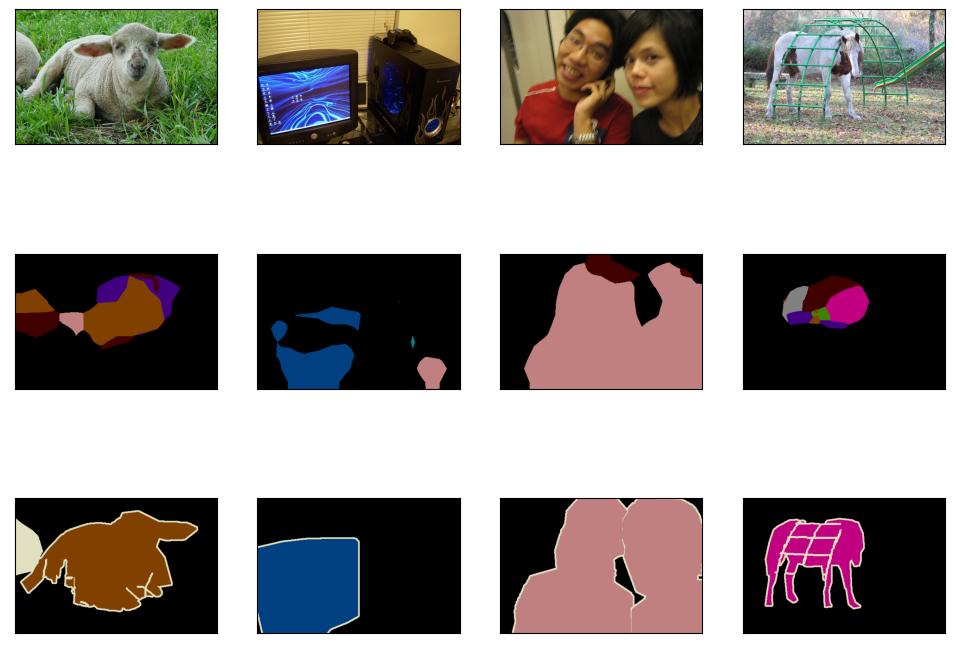

In [37]:
n, imgs = 4, []

img_names = valid_img_names[5:n+5]
test_imgs, test_labels = [], []
for img_name in img_names: 
    img = read_image(os.path.join(img_dir, f'{img_name}.jpg'))              # JPEG images 
    label = read_image(os.path.join(label_dir, f'{img_name}.png'), mode)    # PNG images 
    test_imgs.append(img)
    test_labels.append(label)

for i in range(n): 
    crop_rect = (0, 0, 320, 480)                     # crop rectangle 
    X = transforms.functional.crop(test_imgs[i], *crop_rect)
    pred = label2image(predict(X), colormaps)
     
    imgs += [X,                                           # cropped input image 
             pred.permute(2, 0, 1).cpu(),                 # predicted segmented image 
             transforms.functional.crop(test_labels[i], *crop_rect)]
    
show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=3)